# Finding downgraded crimes using machine learning

Using a machine learning algorithm, The Los Angeles Times found the LAPD was downgrading serious assaults to the less serious "simple assault" category for years. We're going to reproduce this by manually downgrading 15% of the serious assaults in a database, then trying to see if we can detect which ones we edited.

We'll be using actual assault reports from the LAPD, reported between the years of 2008-2012. 

<p class="reading-options">
  <a class="btn" href="/latimes-crime-classification/actual-analysis">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/latimes-crime-classification/notebooks/Actual analysis.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **2008-2012.csv:** cleaned crime reports - a selection of partially scrubbed reports from between 2008-2012


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/latimes-crime-classification/data/2008-2012.csv.zip -P data
!unzip -n -d data data/2008-2012.csv.zip

## Imports and setup

First we'll set some options up to make everything display correctly. It's mostly because these assault descriptions can be quite long, and the default is to truncate text after a few words.

In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

%matplotlib inline

## Read in our data

Our dataset is going to be a database of crimes committed between 2008 and 2012. The data has been cleaned and filtered a bit, though, so we're only left with two columns:

* `CCDESC`, what criminal code was violated
* `DO_NARRATIVE`, a short text description of what happened

We're going to use this description to see if we can separate serious cases of assault compared to non-serious cases of assault.

In [2]:
df = pd.read_csv("data/2008-2012.csv")
df.head(10)

,CCDESC,DO_NARRATIVE
0,SHOPLIFTING - PETTY THEFT ($950 & UNDER),DO-SUSP WAS SEEN THROUGH SURVAILANCE CONCEALING SEVERAL ITEMS INTO HER SHOPPING AND PERSONAL BAG LEAVING WITHOUT PAYING DEPT STORE
1,VIOLATION OF COURT ORDER,DO-SUSP ARRIVED AT VICTS RESID AND ENTERED VICTS RESID IN VIOLATION OF RESTRAINING ORDER
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPRCHED V AND STATED ARE YOU GOING TO FCK ME V REPLIED NO SUSP PULL ED OUT A KNIFE AND STATED IM HERE TO HURT YOU BTCH S USED PROFANITIES
3,THEFT PLAIN - PETTY ($950 & UNDER),DO-UNK SUSP TOOK VICT PREPAID GIFT CARD SUSP PURCHASED PRODUCTS WITH ITEM
4,BATTERY - SIMPLE ASSAULT,DO-SUSP USED RIGHT FIST TO PUNCH VICT IN THE HEAD ONCE N PULL VICT HAIR FOR APPRX 15 SECONDS
5,THEFT OF IDENTITY,DO-UNK SUSP USED VICTS PERSONAL INFO FOR GAIN WITHOUT THE VICTS CONSENT ORKNOWLEDGE
6,SHOPLIFTING - PETTY THEFT ($950 & UNDER),DO-SUSP ENTERED MKT AND SEL ITEMS SUSP CONCEALED ITEMS AND EXITED STORE WOPAYING
7,BURGLARY,DO-UNK SUSP ENTERED VICTS RESIDENCE BY UNLOCKED FRONT DOOR SUSP REMOVED VCTICTS PROPERTY SUSP FLED LOC
8,OTHER MISCELLANEOUS CRIME,DO-SUSP ADMITTED TO PLACING 2010 REG TAG HE ILLEGALLY OBTAINED ON HIS LIC PLATE HIS VEH REG WAS STILL EXP
9,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V IN VEH S SLAPPED AND LUNGGED AT V


How much data do we have?

In [3]:
df.shape

(830218, 2)

# Clean the data

We don't get to use all 800,000 rows, though! We're just going to stick to assaults. First we'll filter our dataset to only include crimes with a description that includes the word `ASSAULT`.

In [4]:
df = df[df.CCDESC.str.contains("ASSAULT")].copy()
df.shape

(165965, 2)

Assaults come in two forms:

* Serious or Part I assaults, which are Aggravated and Serious assaults
* Non-Serious or Part II assaults, which are Simple assaults

Let's make a new column called `serious` where we save whether the assault is serious/Part I or not.

In [5]:
df['serious'] = df.CCDESC.str.contains("AGGRAVATED") | df.CCDESC.str.contains("DEADLY")
df['serious'] = df['serious'].astype(int)
df.groupby('serious').CCDESC.value_counts()

serious  CCDESC                                        
0        BATTERY - SIMPLE ASSAULT                          71951
         INTIMATE PARTNER - SIMPLE ASSAULT                 42102
         CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT            4297
         OTHER ASSAULT                                       394
1        ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    43385
         INTIMATE PARTNER - AGGRAVATED ASSAULT              1606
         CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT        1481
         ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER        749
Name: CCDESC, dtype: int64

How many are serious vs simple assaults?

In [6]:
df.serious.value_counts()

0    118744
1     47221
Name: serious, dtype: int64

We have about 2.5x as many serious assaults as we do simple assaults. Typically you want to have equal numbers of both, but we'll see how it goes for now.

## Downgrading some serious assaults

The Los Angeles Times looked for (and found) Part I crimes that the LAPD had downgraded to Part II. We don't have access to these original attributions, though, so we'll need to randomly select serious crimes to downgrade.

Let's take 15% of the serious crimes and downgrade them to Part II. I'd rather not save this in another file because I don't want to imply it's real - **it's just us faking the downgrade for the purposes of the exercise.**

In [7]:
# Select a random sample of 15% of the part I crimes
serious_subset = df[df.serious == 1].sample(frac=0.15)

# So we can flag the ones we're downgrading
df['downgraded'] = 0

# Update the original dataframe to downgrade them to part_ii
df.loc[serious_subset.index, 'downgraded'] = 1
df.loc[serious_subset.index, 'serious'] = 0

How many did we downgrade?

In [8]:
df.downgraded.sum()

7083

Before we had 118,744 simple assaults and 47,221 serious assaults. What's that number look like now?

In [9]:
df.serious.value_counts()

0    125827
1     40138
Name: serious, dtype: int64

And now we'll take a look at some of the downgraded assaults. Bear in mind that **we selected the assaults to downgrade randomly.**

In [10]:
df[df.downgraded == 1].head(10)

,CCDESC,DO_NARRATIVE,serious,downgraded
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPRCHED V AND STATED ARE YOU GOING TO FCK ME V REPLIED NO SUSP PULL ED OUT A KNIFE AND STATED IM HERE TO HURT YOU BTCH S USED PROFANITIES,0,1
64,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP DROVE TO THE DRIVER SIDE OF THE VICTS VEH S1 FRNT PSGR OF THE SUPSVEH PRODUCED HANDGUN FIRED APPROX FIVE ROUNDS AT VICT ASSIGNED TO GANG DETS,0,1
87,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,DO-V WAS STRUCK WITH BELT,0,1
243,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP DROVE UP ALONG SIDE VICTS DRIVER SIDE WINDOW AND STATED BITCH YOU TRIED TO HIT MY SON SUSP REMOVED BOTTLE WITH RIGHT HAND AND THREW IT AT VICT,0,1
716,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO- S YELLED AT V FUK SOUTH LOS AND SHOT 8X WITH HANDGUN AT V WHO WAS IN V VEH S FLED ON FOOT TO UNK LOC,0,1
778,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO- SUSP BECAME ANGRY AT VICT CHALLENGED TO FIGHT PULLED HANDGUN FROM REARWAISTBAND PRESSED AGAINST VICTS HEAD AND PULLED TRIGGER MAKING CLICK SUSP STAT,0,1
1069,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S1 FIRED AT UNK MOTORIST AND STRUCK VICT VEH S2 STOOD BY AS A LOOKOUT,0,1
1184,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-V TRIED TO BREAK UP FIGHT BETWEEN WIT AND S S STABBED V ON THE ABDOMEN S FLED IN VEH IN UNK DIR,0,1
1519,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSPS AND VICT WERE INVOVLED IN VERBAL DISPUTE SUSPS BECAME UPSET AND STRUCK VICT W WOODEN STICKS CAUSING INJURY,0,1
1736,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSPS1-3 PUNCHED AND KICKED VIC CAUSING A SMALL CONTUSION BEHIND HER RTEAR AND TO LOSE CONSCIOUSNESS,0,1


# Time to classify

Now we're going to build a classifier that can predict whether an assault is serious or non-serious. To do that, we first need to count all the words in each description.

## Stemming

When we talk about "words," we can mean a few different things. Do you feel like "stab," "stabbed," and "stabbing" should all count the same? If yes, you're interested in **stemming.**

Stemming is the process of trying to convert words to their root. There are a few different kinds of stemmers, but we'll be using one called **SnowballStemmer** that comes with NLTK.

In [11]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

Let's see how it works in the case of different tenses of the word "stabbing:"

In [12]:
print(stemmer.stem("stab"))
print(stemmer.stem("stabbed"))
print(stemmer.stem("stabbing"))

stab
stab
stab


Looks good! It also works with singular and plurals.

In [13]:
print(stemmer.stem("gun"))
print(stemmer.stem("guns"))

gun
gun


It can have trouble with more complicated words, though. Here's an example with "knife" as compared to "knives."

In [14]:
print(stemmer.stem("knife"))
print(stemmer.stem("knifed"))
print(stemmer.stem("knives"))

knife
knife
knive


If it gets most of what we're looking for, though, I think we're okay.

## Building a vectorizer that uses stemming

Vectorizing is the process of converting words to numbers, and counting each of them (along with any other transformations). It's a little complex to incorporate stemming into the process, but here we go.

We're also using a `TfidfVectorizer`, which doesn't count words exactly. More common words become less meaningful, and words in short sentences mean more than words in longer sentences.

For example, your name showing up in a tweet probably means the tweet is about you. If your name shows up once in a big, big book, though, the chances are much lower that the entire book is about you.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer,self).build_analyzer()
        return lambda doc:(stemmer.stem(word) for word in analyzer(doc))

Now we'll actually use our vectorizer to count the words. We're being a little picky, in that:

* We're only using words that show up at least 15 times in our dataset, and
* We're ignoring anything that shows up in more than half of the police reports

This helps cut down on noise. Adjusting the terms will give us a greater or fewer number of words, and might also affect our accuracy later on.

In [16]:
%%time

vectorizer = StemmedTfidfVectorizer(min_df=15, max_df=0.5)

X = vectorizer.fit_transform(df.DO_NARRATIVE)
X

CPU times: user 1min 8s, sys: 859 ms, total: 1min 9s
Wall time: 1min 15s


<165965x3417 sparse matrix of type '<class 'numpy.float64'>'
	with 2119793 stored elements in Compressed Sparse Row format>

If we're only paying attention to words that show up at least 15 times, and are ignoring words that show up in half of the reports, how many words we we using?

In [17]:
len(vectorizer.get_feature_names())

3417

## Examining our words

While it doesn't do us much good in terms of analysis, we can take a pick look at our words and sentences to see what shows up where.

In [18]:
words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
words_df.head(10)

,01,08,09,10,100,101,103rd,10time,10x,10yr,11,112,112th,118,11th,11yr,12,12yr,13,14,14yr,15,15yr,16,16yr,17,18,18th,18yr,19,1cic,1s,1st,1x,1yr,20,20yr,21,22,23,23rd,24,25,25yr,28th,2gether,2mos,2nd,2time,2x,...,witmer,wk,wks,wlkd,wlkng,wndw,wo,woke,woman,women,wood,wooden,woodman,word,work,worker,workplac,would,wouldnt,wound,wout,wrap,wre,wrench,wrestl,wrist,write,wrong,wrote,ws,wth,wtih,wy,xboyfriend,xs,yall,yank,yard,year,yell,yellow,yes,yo,you,younger,your,yourself,yr,yrs,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.296974,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205927,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.224758,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Classify

> "SVM models perform better on sparse data than does trees in general. For example in document classification you may have thousands, even tens of thousands of features and in any given document vector only a small fraction of these features may have a value greater than zero."
>
> https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f

In [19]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

In [20]:
X = words_df
y = df.serious

In [21]:
%%time

clf = LinearSVC()
clf.fit(X, y)

CPU times: user 6 s, sys: 6.3 s, total: 12.3 s
Wall time: 16.6 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## What words are important?

Before we see how our classifier performs, let's take a look at which words point towards a report being either simple or aggravated assault. In this case, we're going to look at the top and bottom 20 terms.

In [32]:
# This is the older way to do it, leaving it here for historical reasons

# top_features = 20
# feature_names = vectorizer.get_feature_names()

# coef = clf.coef_.ravel()
# sorted_coefs = np.argsort(coef)
# coef_indices = np.r_[0:top_features, -top_features:0]
# top_coefficients = sorted_coefs[coef_indices]

# terms = np.array(feature_names)[top_coefficients]
# coefs = coef[top_coefficients]

# terms = pd.DataFrame({'coef': coefs }, index=terms)
# terms.sort_values(by='coef', ascending=False)

In [34]:
import eli5

eli5.show_weights(clf, vec=vectorizer, top=(20, 20))

Weight?,Feature
+2.652,stab
+2.244,degre
+2.222,shot
+2.207,bat
+2.156,knife
+2.145,andstab
+2.102,stabe
+2.050,great
+1.981,shovel
+1.898,brass


If we jump through a couple hoops, we can also have a nice colored graphic!

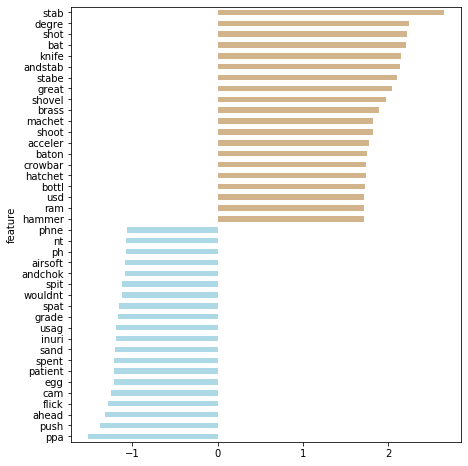

In [63]:
# Build a dataframe of what we have above
weights = eli5.explain_weights_df(clf, vec=vectorizer, top=(20, 20))

# Pick colors based on being above or below zero
colors = weights.weight.apply(lambda weight: 'lightblue' if weight > 0 else 'tan')

# Sort it and plot it
weights.sort_values(
    by='weight',
    ascending=True
).plot(
    y='weight',
    x='feature',
    kind='barh',
    figsize=(7,8),
    color=colors,
    legend=False
)

Lots of interesting stuff in there!

* Does it sound reasonable which terms imply aggravated vs simple assault?
* Which ones are misspellings? Does that worry you?
* Are there any terms in there you don't quite get?

There's another notebook - "Inspecting misclassifications" - that goes a bit deeper into these terms and what they may (or may not) mean.

## Making predictions

No matter what the terms are that point to a report being filed as Part I or Part II, at the end of the day we're interested in seeing **how good is our model as making predictions?** To test it out, we'll need to perform some predictions on content we know the answer to. Let's start by seeing how it does on some sample sentences.

In [24]:
sample_X = vectorizer.transform(['SWUNG A MACHETE AND CUT VIC HAND'])
clf.predict(sample_X)

array([1])

In this case `1` means that yes, it was a serious assault. Let's try a few more.

In [25]:
examples = pd.DataFrame({ 
    'content': [
        'SWUNG A MACHETE AND CUT VIC HAND',
        'GRABBED VIC AND SHOOK VERY HARD',
        'SHOT VIC ONE TIME IN LEFT LEG',
        'PUNCHED VIC IN FACE',
        'SLAPPED VIC AND BROKE NOSE',
        'BURNED VIC WITH HOT IRON'
    ]
})

examples_X = vectorizer.transform(examples.content)
examples['prediction'] = clf.predict(examples_X)
examples

,content,prediction
0,SWUNG A MACHETE AND CUT VIC HAND,1
1,GRABBED VIC AND SHOOK VERY HARD,0
2,SHOT VIC ONE TIME IN LEFT LEG,1
3,PUNCHED VIC IN FACE,0
4,SLAPPED VIC AND BROKE NOSE,0
5,BURNED VIC WITH HOT IRON,1


You can see that offenses that include weapons tend to be predicted as serious offenses, while ones involving punching or other direct physical contact are classified as simple assault.

Instead of just looking at which category a report was put in, we can also look at **the score the classifier used for the prediction.**

In [26]:
examples['prediction_dist'] = clf.decision_function(examples_X)
examples

,content,prediction,prediction_dist
0,SWUNG A MACHETE AND CUT VIC HAND,1,0.988718
1,GRABBED VIC AND SHOOK VERY HARD,0,-0.699699
2,SHOT VIC ONE TIME IN LEFT LEG,1,0.114073
3,PUNCHED VIC IN FACE,0,-1.211098
4,SLAPPED VIC AND BROKE NOSE,0,-1.236884
5,BURNED VIC WITH HOT IRON,1,0.475308


The further away from zero, more certain the algorithm is in its prediction.

* **SHOT VIC ONE TIME IN LEFT LEG** scores `0.221241`, so it isn't very sure that it's serious
* **SLAPPED VIC AND BROKE NOSE** sounds violent, but it scores `-1.254914` so the algorithm is pretty certain it's not a serious offense.

Now we can move on to making comparisons with our actual dataset.

# Making predictions to find downgraded crimes

To see if our algorithm can find downgraded reports, we'll first ask it to make predictions on each of the descriptions we have. If a report is listed as not serious, but the algorithm thinks it should be serious, we should examine the report further.

In [27]:
# Feed the classifier the word counts (X) to have it make the prediction
df['prediction'] = clf.predict(X)

# Let's also how certain the classifier is
df['prediction_dist'] = clf.decision_function(X)

df.head()

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPRCHED V AND STATED ARE YOU GOING TO FCK ME V REPLIED NO SUSP PULL ED OUT A KNIFE AND STATED IM HERE TO HURT YOU BTCH S USED PROFANITIES,0,1,1,0.039799
4,BATTERY - SIMPLE ASSAULT,DO-SUSP USED RIGHT FIST TO PUNCH VICT IN THE HEAD ONCE N PULL VICT HAIR FOR APPRX 15 SECONDS,0,0,0,-1.049685
9,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V IN VEH S SLAPPED AND LUNGGED AT V,0,0,0,-0.267440
11,BATTERY - SIMPLE ASSAULT,DO-V STATED THAT SUSP CONFRT HER WHEN SHE TRIED TO APPR HER HUSBAND SUSP AND V HUSBAND ARE FRNDS SUSP YELLED STAY AWAY FROM HIM AND PUSHED V,0,0,0,-1.165267
16,BATTERY - SIMPLE ASSAULT,DO-SUSPS WERE VERBALLY ABUSING VICT DURING WHICH TIME S1 STRUCK VICT THREETIMES ON THE BACK OF HIS LEFT SHOULDER,0,0,0,-0.924740


Crimes with a `1` in **serious** are serious, and ones with a `1` in **downgraded** were downgraded. If either of those columns is `1`, then **prediction** would also be `1` for a correct prediction.

# Let's evaluate our classifier

When you build a classifier, you'll talk about your **evaluation metric**, what you use to judge how well your algorithm performed. Typically this is **accuracy** - how often was your prediction correct?

## How often did our prediction match whether a crime was listed as serious?

In [28]:
(df.prediction == df.serious).value_counts(normalize=True)

True     0.879258
False    0.120742
dtype: float64

88% doesn't seem that bad!

Remember, though, **15% of the serious crimes have been downgraded**. We don't actually care whether the prediction matches **if the crime has been downgraded**. We need to see whether we correctly predicted reports marked as serious *or* downgraded reports.

## How often did we match the true serious/not serious value?

Since we're interested in uncovering the secretly-serious reports, we want to see whether it's serious *or* downgraded.

In [29]:
(df.prediction == (df.serious | df.downgraded)).value_counts(normalize=True)

True     0.891905
False    0.108095
dtype: float64

We actually did better when including the secrets! 89%!

While this seems good, **it isn't what we're actually after.** We're specifically doing research on **finding downgraded reports,** so what we're interested in is **how often we found reports marked as non-serious that were downgraded from serious**.

## How often did we catch downgrades?

To figure this out, we'll first make sure we're only looking at downgraded reports, and then see how many of them we predicted as being serious assault.

In [30]:
# Only select downgraded reports
downgraded_df = df[df.downgraded == 1]

# How often did we predict they were serious?
(downgraded_df.prediction == 1).value_counts(normalize=True)

True     0.648172
False    0.351828
Name: prediction, dtype: float64

In [31]:
# And again, without the percentage, in case you're curious
(downgraded_df.prediction == 1).value_counts()

True     4591
False    2492
Name: prediction, dtype: int64

We were able to find around 4,500 of our 7,000 downgraded offenses. **That's about 65% of them.**

Let's finish up for now and discuss what we think about our techniques and scoring methods. If you're interested in picking apart the ones we got wrong and investigating the algorithm a little further, I recommend the **Inspecting misclassifications** notebook. 

## Review

We reproduced an ersatz version of a Los Angeles Times piece where they uncovered **serious assaults that had been downgraded by the LAPD** to simple assault. We don't have access to the original classifications, so we used a dataset of assaults between 2008 and 2012 and downgraded a random 15% of the serious assaults.

Using **text analysis**, we first analyzed the words used in a description of assault - less common words were given more weight, and incredibly common words were left out altogether. Using these results, we then created a **classifier**, teaching the classifier which words were associated with simple assault compared to aggravated assault.

Finally, we used the classifier to **predict whether each assault was aggravated or simple assault**. If a crime was predicted as serious but marked as non-serious, it needed to be examined as a possible downgrade. Our algorithm correctly pointed out around **65%** of the randomly downgraded crimes.

## Discussion topics

* Our algorithm had 88% accuracy overall, but only 65% in detecting downgraded crimes. What's the difference here? How important is one score compared to the other?
* We only hit around 65% accuracy in finding downgraded crimes. Is this a useful score? How does it compare to random guessing, or going one-by-one through the crimes marked as non-serious?
* What techniques could we have used to find downgraded crimes if we didn't use machine learning?
* Is there a difference between looking at the prediction - the 0 or 1 - and looking at the output of `decision_function`?
* What happens if our algorithm errs on the side of calling non-serious crimes serious crimes? What if it errs on the side of calling serious crimes non-serious crimes?
* If we want to find more downgraded cases (but do more work), we'll want to err on the side of examining more potentially-serious cases. Is there a better method than picking random cases?
* One of our first steps was to eliminate all crimes that weren't assaults. How do you think this helped or hindered our analysis?
* Why did we use LinearSVC instead of another classifier such as LogisticRegression, RandomForest or Naive Bayes (MultinomialNB)? Why might we try or not try those?
* You don't work for the LAPD, so you can only be so sure what should and shouldn't be a serious crime. What can you do to help feel confident that a case should be one or the other, or that our algorithm is working as promised?
* In this case, we randomly picked serious crimes to downgrade. Would it be easier or more difficult if the LAPD was systematically downgrading certain types of serious crimes? Can you think of a way to around that sort of trickery?
* Many people say you need to release your data and analysis in order to have people trust what you've done. With something like this dataset, however, you're dealing with real things that happened to real people, many of whom would probably prefer to keep these things private. Is that a reasonable expectation? If it is, what can be done to bridge the gap between releasing all of the original data and keeping our process secret?